In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
import torch # torch.utils.bottleneck cProfile ?
import json
import os
plt.ion()  
from IPython.display import clear_output, display
from pathlib import Path
from time import sleep

from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode
from MAPPO_agent import MAPPO_agent
from RelicBound.agent import Agent as RelicboundAgent

save_replays = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# INITIALIZE

In [2]:
def from_json(state):
    if isinstance(state, list):
        return np.array(state)
    elif isinstance(state, dict):
        out = {}
        for k in state:
            out[k] = from_json(state[k])
        return out
    else:
        return state 
    
# slower?
if save_replays:
    env = RecordEpisode(LuxAIS3GymEnv(numpy_output=True), save_on_reset=False, save_on_close=False)
else:
    env = LuxAIS3GymEnv(numpy_output=True)
seed = np.random.randint(9999999)
obs, info = env.reset(seed=seed)
env_cfg = info['params'] # this is passed in the original main file as configurations["env_cfg"]


# PLOTTING & SAVING

In [3]:

def create_plot_grid(run_name, config):
    """
    Creates a 3x4 grid of subplots with an overall title that includes the run name and config.
    """
    fig, axs = plt.subplots(3, 4, figsize=(30, 12))
    # Set an overall title for the figure (suptitle)
    fig.suptitle(f"{run_name}", fontsize=14)
    # Adjust layout to account for the suptitle (rect defines the subplot area)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    return fig, axs

def update_plots(fig, axs,
                 match_wins,
                 actor_loss_list,
                 critic_loss_list,
                 entropy_list,
                 policy_ratio_list,
                 clipping_fraction_list,
                 advantages_mean_list,
                 value_absolute_error_list,
                 grad_norm_list,
                 match_points,
                 reward_list,
                #  ship_reward_list,
                 ship_reward_means_list,
                 ship_reward_stds_list):
    # Episode Wins (1D)
    axs[0, 0].clear()
    axs[0, 0].plot(match_wins, marker='o')
    axs[0, 0].set_title("Episode Wins")
    
    # Actor Loss (2D: [mean, std])
    axs[0, 1].clear()
    actor_data = np.array(actor_loss_list)
    axs[0, 1].errorbar(range(actor_data.shape[0]),
                         actor_data[:, 0],
                         yerr=actor_data[:, 1],
                         marker='o', color='tab:blue', linestyle='-')
    axs[0, 1].set_title("Actor Loss")
    
    # Critic Loss (2D: [mean, std])
    axs[0, 2].clear()
    critic_data = np.array(critic_loss_list)
    axs[0, 2].errorbar(range(critic_data.shape[0]),
                         critic_data[:, 0],
                         yerr=critic_data[:, 1],
                         marker='o', color='tab:orange', linestyle='-')
    axs[0, 2].set_title("Critic Loss")
    
    # Entropy (2D: [mean, std])
    axs[0, 3].clear()
    entropy_data = np.array(entropy_list)
    axs[0, 3].errorbar(range(entropy_data.shape[0]),
                         entropy_data[:, 0],
                         yerr=entropy_data[:, 1],
                         marker='o', color='tab:green', linestyle='-')
    axs[0, 3].set_title("Entropy")
    
    # Clipping Fraction (2D: [mean, std])
    axs[1, 0].clear()
    clipping_data = np.array(clipping_fraction_list)
    axs[1, 0].errorbar(range(clipping_data.shape[0]),
                         clipping_data[:, 0],
                         yerr=clipping_data[:, 1],
                         marker='o', color='tab:purple', linestyle='-')
    axs[1, 0].set_title("Clipping Fraction")
    
    # Advantages Mean (2D: [mean, std])
    axs[1, 1].clear()
    adv_data = np.array(advantages_mean_list)
    axs[1, 1].errorbar(range(adv_data.shape[0]),
                         adv_data[:, 0],
                         yerr=adv_data[:, 1],
                         marker='o', color='tab:brown', linestyle='-')
    axs[1, 1].set_title("Returns")
    
    # Value Estimate Absolute Error (2D: [mean, std])
    axs[1, 2].clear()
    value_error_data = np.array(value_absolute_error_list)
    axs[1, 2].errorbar(range(value_error_data.shape[0]),
                         value_error_data[:, 0],
                         yerr=value_error_data[:, 1],
                         marker='o', color='tab:pink', linestyle='-')
    axs[1, 2].set_title("Value Estimate Absolute Error")
    
    # Gradient Norms (2D: [mean, std])
    axs[1, 3].clear()
    grad_norm_data = np.array(grad_norm_list)
    axs[1, 3].errorbar(range(grad_norm_data.shape[0]),
                         grad_norm_data[:, 0],
                         yerr=grad_norm_data[:, 1],
                         marker='o', color='tab:cyan', linestyle='-')
    axs[1, 3].set_title("Actor Gradient Norms")
    
    # Policy Ratio (2D: [mean, std])
    axs[2, 0].clear()
    policy_ratio_data = np.array(policy_ratio_list)
    axs[2, 0].errorbar(range(policy_ratio_data.shape[0]),
                         policy_ratio_data[:, 0],
                         yerr=policy_ratio_data[:, 1],
                         marker='o', color='tab:red', linestyle='-')
    axs[2, 0].set_title("Policy Ratio")
    
    # Reward (2D: [mean, std])
    axs[2, 1].clear()
    reward_data = np.array(reward_list)
    axs[2, 1].errorbar(range(reward_data.shape[0]),
                         reward_data[:, 0],
                         yerr=reward_data[:, 1],
                         marker='o', color='tab:red', linestyle='-')
    axs[2, 1].set_title("Reward")
    
    # Ship Reward (2D: [mean, std] across steps)
    axs[2, 2].clear()
    try:
        means_array = np.vstack([elem[0] for elem in ship_reward_means_list])
        stds_array = np.vstack([elem[0] for elem in ship_reward_stds_list])
        colors = plt.cm.get_cmap('tab20', 16)
        for i in range(16):
            axs[2, 2].errorbar(
                range(means_array.shape[0]),  # x-axis: update indices
                means_array[:, i],            # y-axis: mean reward for ship i
                yerr=stds_array[:, i],        # error bar: std for ship i
                marker='o',
                linestyle='-',
                color=colors(i),
                label=f"Ship {i}"
            )
    except Exception as e: 
        means_array = np.array([elem[0] for elem in ship_reward_means_list]).flatten()
        stds_array = np.array([elem[0] for elem in ship_reward_stds_list]).flatten()
        axs[2, 2].errorbar(
            np.arange(means_array.shape[0]),  # x-axis: update indices
            means_array,                      # y-axis: mean reward per update
            yerr=stds_array,                  # error bars: std deviation per update
            marker='o',
            linestyle='-',
            color='blue',                     # or choose another color
            label="Ship Reward"
        )

    axs[2, 2].set_title("Ship Reward")
    axs[2, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    # Match Points (1D data for each player)
    axs[2, 3].clear()
    axs[2, 3].plot(match_points[1], marker='o', color='tab:red', label='Player 1')
    axs[2, 3].plot(match_points[0], marker='o', color='tab:blue', label='Player 0')
    axs[2, 3].set_title("Match Points")
    axs[2, 3].set_xlabel("Match Number")
    axs[2, 3].set_ylabel("Score")
    axs[2, 3].legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    # Clear previous output and display the updated figure
    clear_output(wait=True)
    display(fig)
    sleep(0.001)


def save_plot(fig, run_name, filename="plot.png"):
    save_dir = os.path.join("runs", run_name)
    os.makedirs(save_dir, exist_ok=True)
    
    file_path = os.path.join(save_dir, filename)
    fig.savefig(file_path)

def save_replay(env, seed, save_dir, total_steps):
    replay = env.serialize_episode_data()
    with open(os.path.join(save_dir, f"replay_{seed}_{total_steps}.json"), "w") as f:
        json.dump(replay, f)

def save_all(agent0, agent1, save_dir, run_name, fig, 
                 match_wins, actor_loss_list, critic_loss_list, 
                 entropy_list, policy_ratio_list, clipping_fraction_list, 
                 advantages_mean_list, value_absolute_error_list, grad_norm_list, 
                 player_0_scores, player_1_scores, reward_list, ship_reward_list, actionlist0, config):
        agent0.save_networks(save_dir)
        # agent1.save_networks(save_dir)
        save_plot(fig, run_name=run_name, filename="final_plot.png")

        # Save the config
        with open(os.path.join(save_dir, "config.txt"), "w") as file:
            json.dump(config, file, indent=4)

        
        def pad_list(lst, target_length, pad_value=np.nan):
            return lst + [pad_value] * (target_length - len(lst))
        max_length = max([len(grad_norm_list),len(player_0_scores),len(player_1_scores),len(reward_list),len(ship_reward_list),len(actionlist0)])
        final_stats = {
            "match_wins": pad_list(match_wins, max_length),
            "actor_loss_list": pad_list(actor_loss_list, max_length),
            "critic_loss_list": pad_list(critic_loss_list, max_length),
            "entropy_list": pad_list(entropy_list, max_length),
            "policy_ratio_list": pad_list(policy_ratio_list, max_length),
            "clipping_fraction_list": pad_list(clipping_fraction_list, max_length),
            "advantages_mean_list": pad_list(advantages_mean_list, max_length),
            "value_absolute_error_list": pad_list(value_absolute_error_list, max_length),
            "grad_norm_list": pad_list(grad_norm_list, max_length),
            "player_0_scores": pad_list(player_0_scores, max_length),
            "player_1_scores": pad_list(player_1_scores, max_length),
            "reward_list": pad_list(reward_list, max_length),
            "ship_reward_list": pad_list(ship_reward_list, max_length),
            "actionlist0": actionlist0
        }
        df = pd.DataFrame(final_stats)
        df.to_csv(os.path.join(save_dir, "final_stats.csv"), index=False)



# TRAINING LOOP

In [4]:
def train(env, num_episodes, config, run_name, rollout, save_freq):
    try:
        save_dir = os.path.join("runs", run_name)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        agent0 = MAPPO_agent("player_0", env_cfg, device=device, **config, save_dir=save_dir)
        # agent0 = RelicboundAgent("player_0", env_cfg)

        # agent1 = MAPPO_agent("player_1", env_cfg, device=device, **config)
        agent1 = RelicboundAgent("player_1", env_cfg) #  relicbound

        # Initialize local lists for the metrics tracked per episode
        match_wins              = []  # Episode Wins (total reward or win indicator)
        actor_loss_list         = []  # Actor (policy) loss
        critic_loss_list        = []  # Critic loss
        entropy_list            = []  # Policy entropy
        policy_ratio_list       = []  # Average policy ratio (new/old probabilities)
        clipping_fraction_list  = []  # Fraction of updates hitting the clipping boundary
        advantages_mean_list    = []  # Mean of advantage estimates
        value_absolute_error_list = []  # Mean error between value estimates and actual returns
        grad_norm_list          = []  # Average gradient norms
        reward_list             = []  # Average reward
        ship_reward_list        = []  # Average ship reward
        ship_reward_means_list  = []  # Average ship reward
        ship_reward_stds_list   = []  # Average ship reward
        player_0_scores         = []
        player_1_scores         = []
        actionlist0             = []
        metric_mapping = { "actor_loss": actor_loss_list,           "critic_loss": critic_loss_list,
                            "entropy": entropy_list,                "policy_ratio": policy_ratio_list,
                            "clipping_fraction": clipping_fraction_list, "advantages_mean": advantages_mean_list,
                            "value_absolute_error": value_absolute_error_list, "grad_norm": grad_norm_list, 
                            "reward": reward_list,                  #"ship_reward": ship_reward_list,
                            "ship_reward_means": ship_reward_means_list, "ship_reward_stds": ship_reward_stds_list
        }
        fig, axs = create_plot_grid(run_name, config)

        total_steps = 0
        for i_episode in range(num_episodes):  # For each episode
            if save_replays or i_episode==(save_freq*rollout): 
                # must make new environment each episode with RecordEpisode
                env = RecordEpisode(LuxAIS3GymEnv(numpy_output = True), save_on_reset=False, save_on_close=False)

            handpicked_seeds = [3008888, 6281631, 2462664, 3856378]
            # run the same seed for each rollout?
            if i_episode % rollout == 0:
                seed = random.choice(handpicked_seeds)
                #seed = np.random.randint(9999999)

            obs, info = env.reset(seed=seed)
            agent0.new_episode(env_cfg=info['params'])
            agent1.new_episode(env_cfg=info['params'])
            
            episode_actionlist0 = []
            episode_actionlist1 = []
            steps_in_episode = 0 # 0-504
            for i_match in range(5):  # For each match within the episode
                for match_steps in range(101):
                    # Actions
                    actions0 = agent0.act(steps_in_episode, from_json(obs["player_0"]), total_steps)
                    actions1 = agent1.act(steps_in_episode, from_json(obs["player_1"]), total_steps)
                    episode_actionlist0.append([int(action[0]) for action in actions0]) # discard sapping target
                    # episode_actionlist1.append([int(action[0]) for action in actions1]) # discard sapping target
                    if match_steps == 100:
                        player_0_scores.append(obs["player_1"]['team_points'][0])  
                        player_1_scores.append(obs["player_1"]['team_points'][1])  
                        if i_match == 4:  # End of episode
                            match_wins.append(obs["player_1"]['team_wins'][0])
                    # Step
                    next_obs, reward, terminated, truncated, info = env.step({ # match_steps 100 effectively resets env
                        "player_0": actions0, "player_1": actions1 
                    })
                    total_steps += 1 # 0-504*num_episodes
                    steps_in_episode += 1   
                    obs = next_obs
                # END MATCH
            # END EPISODE
            if save_replays or i_episode==(save_freq*rollout):
                save_replay(env, seed, save_dir, i_episode) #total_steps

            # 6 numbers for % of action used in each episode
            counts = [0] * 6
            for match_actionlist in episode_actionlist0:
                for i in range(6):
                    counts[i] += match_actionlist.count(i)
            actionlist0.append([int(counts[i] * 100 / (505*16)) for i in range(6)])

            # After the episode, aggregate the metrics from all learning updates that occurred
            if agent0.latest_metrics is not None:
                for key, metric_list in metric_mapping.items():
                    metric_list.append(agent0.latest_metrics.get(key, np.nan))
                # Reset
                agent0.latest_metrics = None
                # End of episode: update the plots with the local metric lists
                update_plots(fig, axs,
                            match_wins, actor_loss_list, critic_loss_list,
                            entropy_list, policy_ratio_list, clipping_fraction_list,
                            advantages_mean_list, value_absolute_error_list, grad_norm_list,
                            [player_0_scores, player_1_scores], reward_list, ship_reward_means_list, ship_reward_stds_list)
            # END EPISODE
        # END TRAINING
        save_all(agent0, agent1, save_dir, run_name, fig, 
                 match_wins, actor_loss_list, critic_loss_list, 
                 entropy_list, policy_ratio_list, clipping_fraction_list, 
                 advantages_mean_list, value_absolute_error_list, grad_norm_list, 
                 player_0_scores, player_1_scores, reward_list, ship_reward_list, actionlist0, config)
        plt.ioff()
        plt.show()
    except KeyboardInterrupt:  
        save_all(agent0, agent1, save_dir, run_name, fig, 
                 match_wins, actor_loss_list, critic_loss_list, 
                 entropy_list, policy_ratio_list, clipping_fraction_list, 
                 advantages_mean_list, value_absolute_error_list, grad_norm_list, 
                 player_0_scores, player_1_scores, reward_list, ship_reward_list, actionlist0, config)
        plt.ioff()
        plt.show()
        raise KeyboardInterrupt


# HYPERPARAMETERS & MODELS

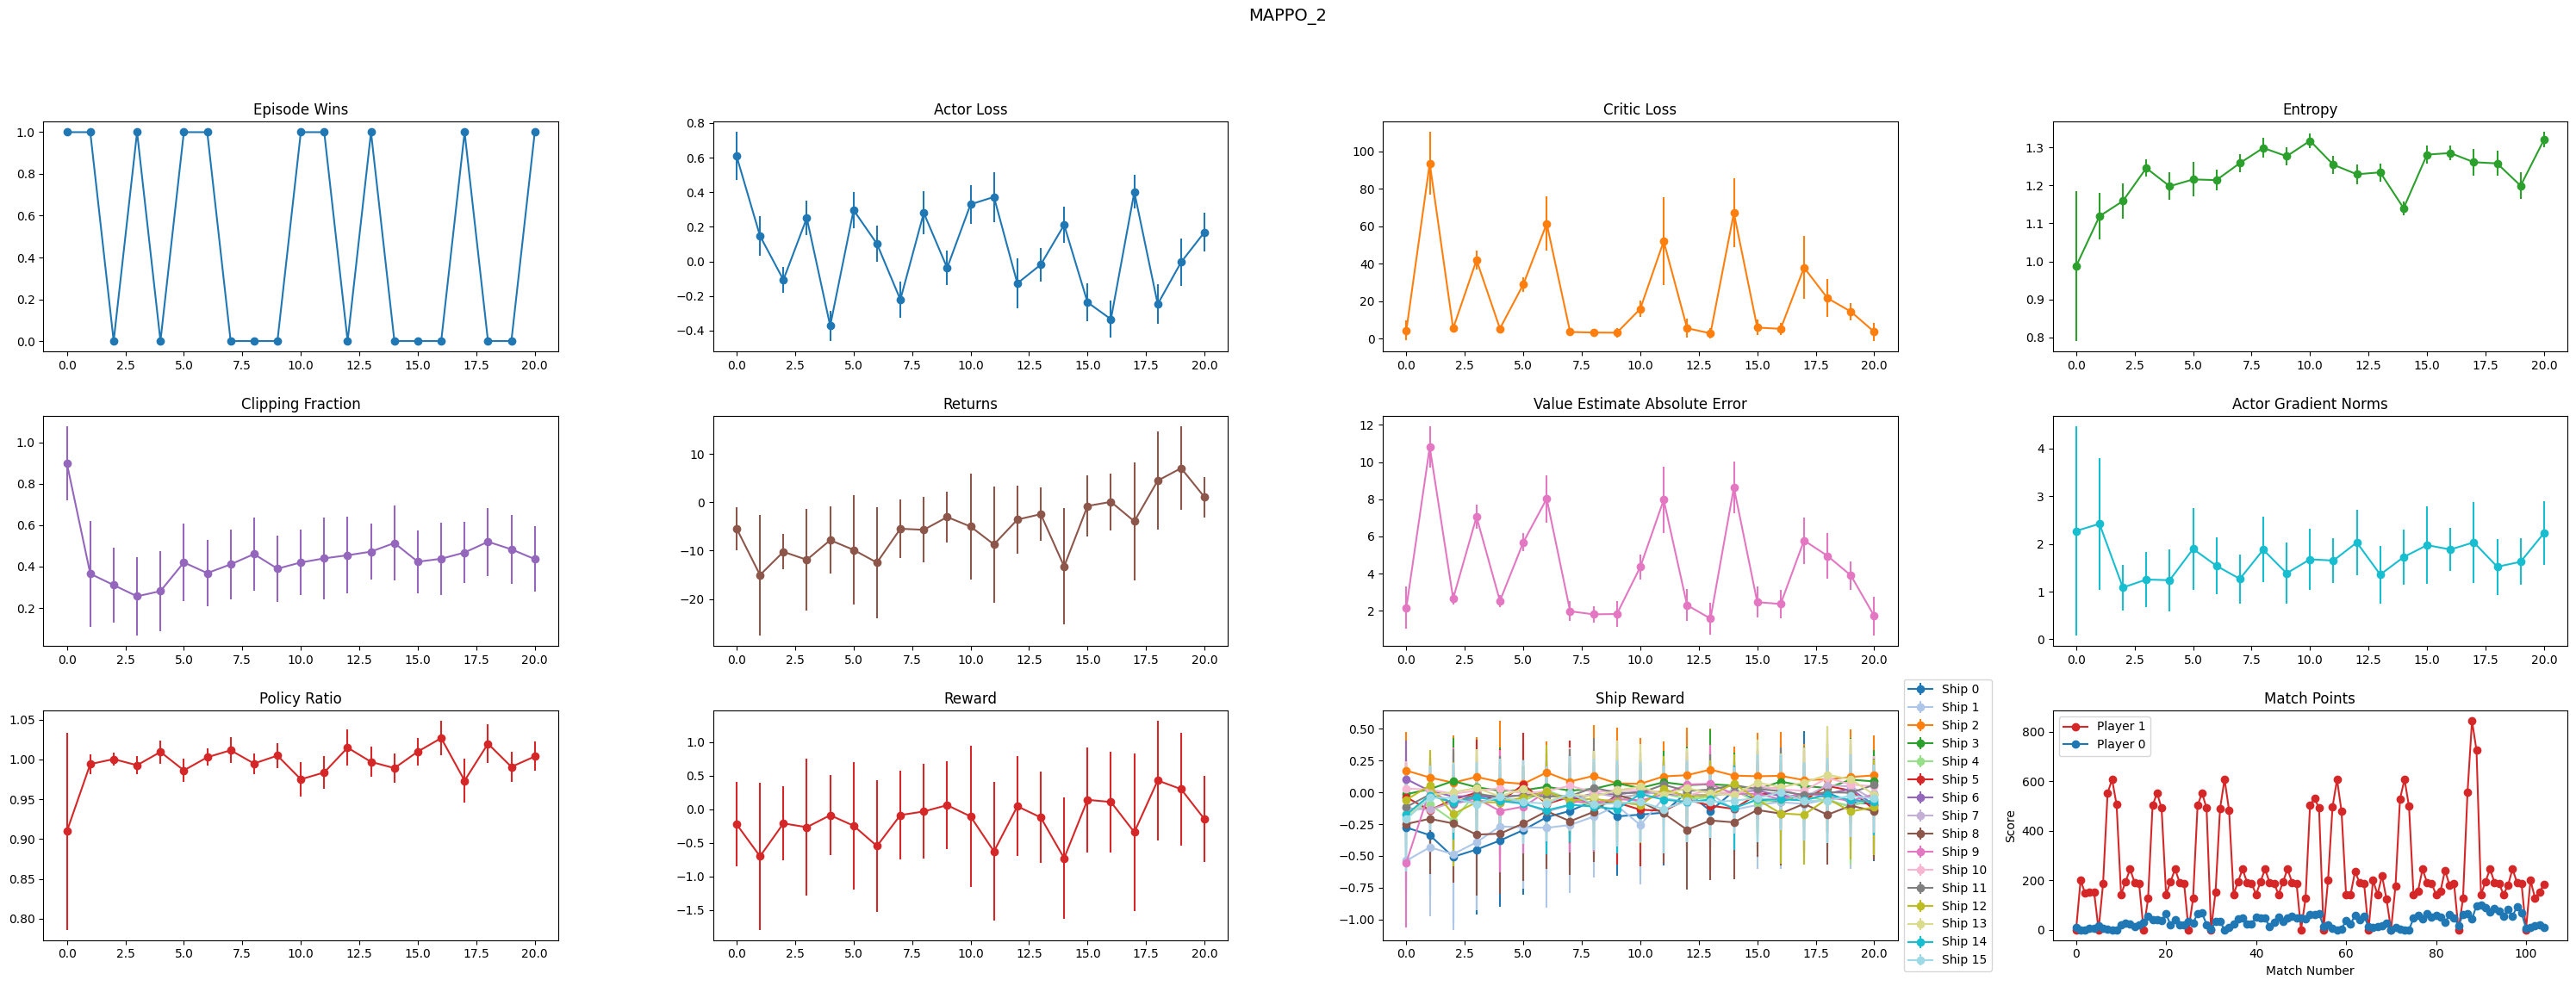

In [ ]:

num_episodes = 5000 
rollout = 1
save_freq = 50
config = {
    "train_mode": [True],
    "buffer_size": [600],
    "action_dim": [5],         # 6
    "lr": [1e-4],              
    "gamma": [0.99],
    "lam": [0.95],
    "eps_clip": [0.1],         # 0.2] larger =less stable, faster - analogous to trust region TRPO 
    "batch_size": [128],        # 32]
    "epochs": [8],             # 2]
    "entropy_coef": [0.001, ],    # 0.01] larger =slower, more random actions, more exploration, potentially suboptimal convergence
    "value_coef": [0.5],
    "is_multichannel": [True], 
    "init_orthogonal": [True], # variance of the activations is preserved across layers, well-scaled, better exploration, more stable and efficient 
    "state_shape": [(9, 24, 24)], 
    "ship_state_shape": [(10, 21, 21)],
    "relicbound_warmup": [10], 
    "temperature": [None],      #, 0.5] expiration
    "resize_actor": [True],
    "use_clipped_critic_loss": [False],
    "LR_scheduler": [False],
    "lr_min": [1e-2],
    "LR_num_steps": [1000],
    "rollout": [rollout],
    "match_bonus": [1], # rewards = points_increase / 16.0 # shape (t,) 5–10% of the cumulative match reward
    "episode_bonus": [2], 
    "save_freq": [save_freq], #
    "discovery_reward": [0.5], # possible(1-9)
    "reward_tile_reward": [0.0], # potential_reward = *0.5
    "move_penalty": [0.1], # 0.1
    "use_multiple_actors": [True], # 0.1
    "continue_training_path": [None],# "runs/MAPPO_0"], # 
    #"": [], normalized_ship_rewards, normalize return
}
keys = list(config.keys())
values_lists = [config[k] for k in keys]
i = 2
run_name = "MAPPO_"
for combination in itertools.product(*values_lists):
    current_run_name = run_name + str(i)
    hyper_config = dict(zip(keys, combination))
    train(env, num_episodes, hyper_config, current_run_name, rollout, save_freq)
    i += 1
   

In [ ]:
stop

In [ ]:
:)